# Problem 2.1. 

Read the sequences of Chlamydia trachomatis and Chlamydia psittaci into R, and compute their
GC content. Subsample only the first 50 sequences for each dataset, which we use in all of
the following steps. (5%)

In [1]:
library(data.table)

PSI <- fread("C:/Users/Qba Liu/Documents/STUDIA/BIOINF_MASTER_BERLIN/SEMESTER_I/FOUNDATIONS_IN_MATH_AND_STATISTICS/LAB/PSI.csv")
TRA <- fread("C:/Users/Qba Liu/Documents/STUDIA/BIOINF_MASTER_BERLIN/SEMESTER_I/FOUNDATIONS_IN_MATH_AND_STATISTICS/LAB/TRA.csv")

In [2]:
PSI_sequences <- 1:nrow(PSI)

for (i in 1:nrow(PSI)){
    PSI_sequences[i] <- PSI[i,2]
}

TRA_sequences <- 1:nrow(TRA)

for (i in 1:nrow(TRA)){
    TRA_sequences[i] <- TRA[i,2]
}

In [3]:
PSI_sequences <- PSI_sequences[1:50]
TRA_sequences <- TRA_sequences[1:50]

In [4]:
GC_content <- function(sequence_in){
  GC_content <- 0
  
  for(bp in sequence_in){
    if (bp == "A" || bp == "T" || bp == "C" || bp == "G"){
      if(bp == "G"){GC_content <- GC_content + 1}
      else if (bp == "C"){GC_content <- GC_content + 1}
      else{GC_content <- GC_content}
    }
  }
  seq_in_len <- length(sequence_in)
  return(GC_content/seq_in_len)
}

In [5]:
PSI_GC <- 1:length(PSI_sequences)

for(i in 1:length(PSI_sequences)){
    sequence <- strsplit(as.character(PSI_sequences[i]), "")[[1]]
    GC <- GC_content(sequence)
    PSI_GC[i] <- GC
}

TRA_GC <- 1:length(TRA_sequences)

for(i in 1:length(TRA_sequences)){
    sequence <- strsplit(as.character(TRA_sequences[i]), "")[[1]]
    GC <- GC_content(sequence)
    TRA_GC[i] <- GC
}

# Problem 2.2.

Build a simple decision tree with a single split based on the GC content on the subsampled data.
What is the optimal split and the corresponding classification accuracy? (Hint: this is the same
as assignment 4, just on the smaller dataset.) (5%)

In [6]:
df1 <- data.frame(PSI_GC, rep(1, length(PSI_GC)))
colnames(df1) <- c("GC_content", "Species")
df2 <- data.frame(TRA_GC, rep(0, length(TRA_GC)))
colnames(df2) <- colnames(df1)
data <- rbind(df1, df2)

In [7]:
Gini <- function(dataset, split_variable_idx, outcome_idx, split_point){
  
    L <- dataset[dataset[, split_variable_idx] < split_point, ]
    R <- dataset[dataset[, split_variable_idx] > split_point, ]
    
    # number of 0s in L divided by the length of L and squared
    L_gini_1 <- (nrow(L[L[, outcome_idx] == 0, ])/nrow(L))^2
    # number of 1s in L divided by the length of L and squared
    L_gini_2 <- (nrow(L[L[, outcome_idx] == 1, ])/nrow(L))^2
    # sum of the above
    L_gini <- 1 - (L_gini_1 + L_gini_2)
    
    # number of os in R divided by the length of R and squared
    R_gini_1 <- (nrow(R[R[, outcome_idx] == 0, ])/nrow(R))^2
    # number of 1s in R divided by the length of R and sqaured
    R_gini_2 <- (nrow(R[R[, outcome_idx] == 1, ])/nrow(R))^2
    # sum of the above
    R_gini <- 1 - (R_gini_1 + R_gini_2)
    
    # add the weights
    L_gini <- L_gini*(nrow(L)/nrow(dataset))
    R_gini <- R_gini*(nrow(R)/nrow(dataset))
    # sum of the above
    gini_at_split_point <- L_gini + R_gini
    
    return(gini_at_split_point)
  
}

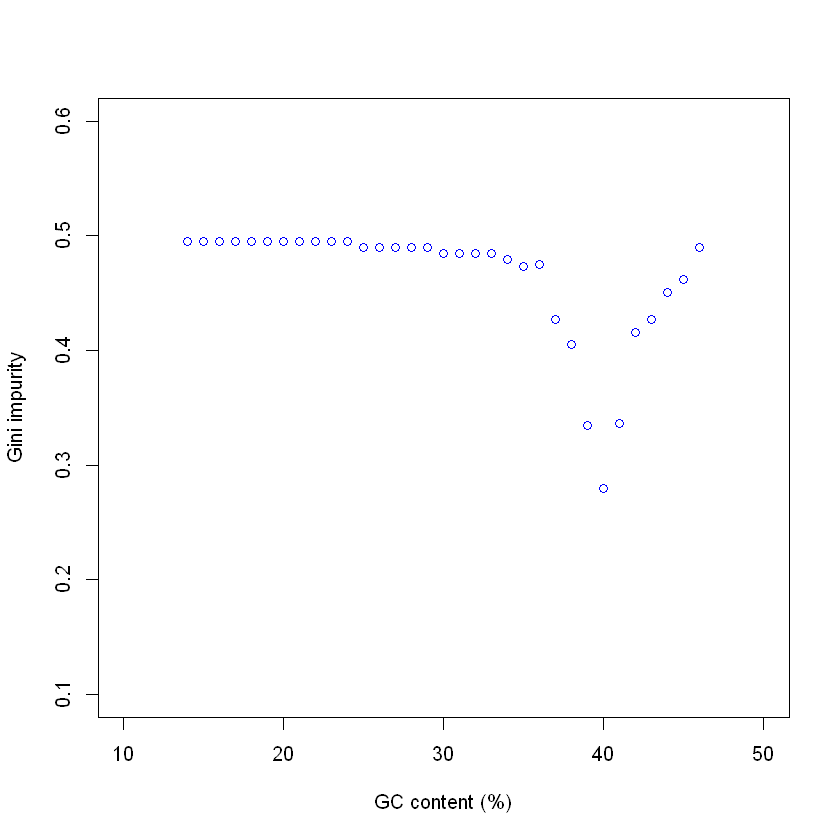

In [8]:
impurity <- c()

for(i in 1:100){
    res <- Gini(dataset = data, split_variable_idx = 1, outcome_idx = 2, split_point = i/100.00)
    impurity <- c(impurity, res)
}

plot(impurity, xlim = c(10,50), ylim = c(0.1, 0.6), col = "blue", xlab = "GC content (%)", ylab = "Gini impurity")

In [9]:
data_low <- data[data$GC_content <= 0.4, ]
data_high <- data[data$GC_content > 0.4, ]

data_low_PSI <- data_low[data_low$Species == 1,]
data_high_TRA <- data_high[data_high$Species == 0,]

accuracy <- (nrow(data_low_PSI) + nrow(data_high_TRA)) / nrow(data)
accuracy <- paste0(accuracy, " %")
print(accuracy)

[1] "0.83 %"


# Problem 2.3.

Build a random forest classifier from 1,000 bootstrap estimators, where each one is a simple decision tree as in step 2 (again, only based on the subsampled data). Compute the the aggregated
bootstrap function gˆBAG. (20%)


In [10]:
# this function return the probabilty that a sequence with a given GC content belongs to either Trachomatis or Psitacchi
# 0 --> 100% Trachomatis
# 1 --> 100% Psitacchi

random_forest <- function(input_GC, n_trees, data){
    predicted_species <- c()
    GC <- 15:50
    GC <- GC/100
    GC_content_threshold <- c()

    for (j in 1:n_trees){  # iterate over n_trees (1000) bootstrap samples
    
            boot <- data[sample(nrow(data),100,replace=TRUE),]
            gc <- c()
            imp <- c()
            best_split_GC <- c()
            min_best_GC <- c()

            for (i in 1:nrow(boot)){  # iterate over each GC content of the given bootstrap sample to find the best split point
                impurity <- Gini(data = boot, split_variable_idx = 1, outcome_idx = 2, split_point = boot[i,1])
                gc <- c(gc, boot[i,1])
                imp <- c(imp , impurity)
                df <- data.frame(gc, imp)
                colnames(df) <- c("gc", "imp")
            }

            # this is the gc content which produces the minimum impurity for the given bootstrap sample
            best_split_GC <- c(best_split_GC, df[which.max(df$imp),]$gc)
            GC_content_threshold <- c(GC_content_threshold, best_split_GC)
            GC_content_threshold <- mean(GC_content_threshold)
        
            # if the input GC content is higher than the calculated GC_content_threshold assign the species Trachomatis
            if (input_GC >= GC_content_threshold){predicted_species <- c(predicted_species, 0)}
    
            # else assign the species Psitacchi
            if (input_GC < GC_content_threshold){predicted_species <- c(predicted_species, 1)}

    }

    # calculate the mean of the predicted species
    return(mean(predicted_species))
}

In [11]:
# example:
#random_forest(input_GC = 0.4, n_trees = 1000)

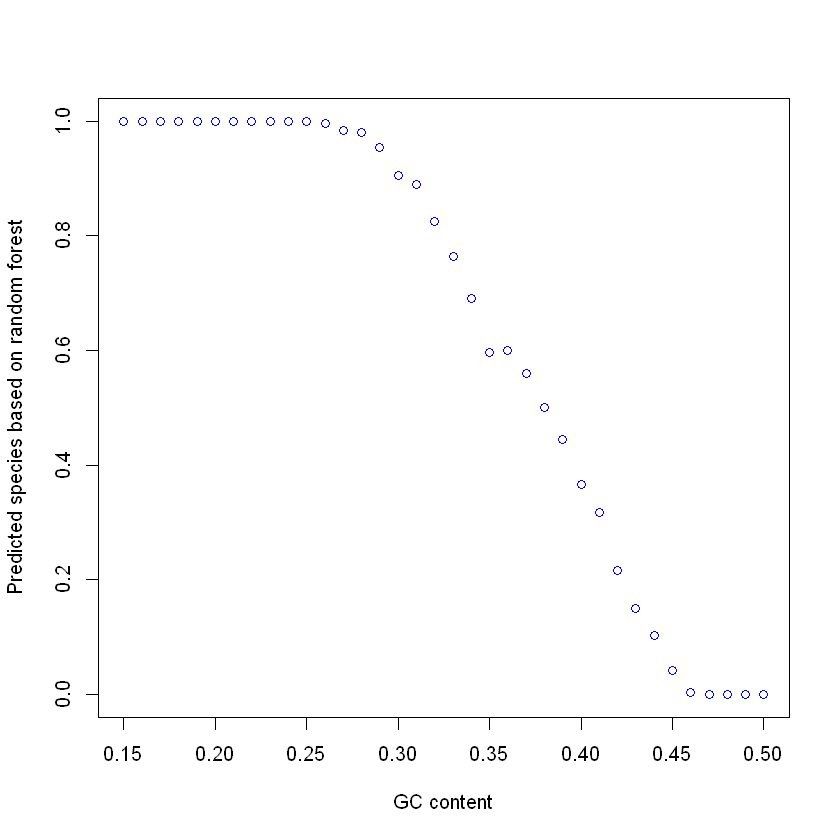

In [15]:
GC_contents <- 15:50
GC_contents <- GC_contents/100
random_forest_output <- c()

for (i in GC_contents){
    random_forest_output <- c(random_forest_output, random_forest(input_GC = i, n_trees = 1000, data = data))
}

plot(GC_contents, random_forest_output, xlab = "GC content", ylab = "Predicted species based on random forest", col = "blue")

# Problem 2.4.

Using 0.5 as the classification threshold, which strain will the random forest classifier predict for
a sequence with a 40% GC content? (10%)

In [13]:
out <- random_forest(input_GC = 0.4, n_trees = 1000, data = data)

decision <- "Trachomatis"

if (out >= 0.5){
    decision <- "Psitacchi"
}

print(decision)

[1] "Trachomatis"


# Problem 2.5.

Perform leave-one-out cross-validation to compute the accuracy of the random forest classifier.
(10%)

In [14]:
num_correct <- 0

for (i in 1:nrow(data)){
    train_data <- data[-i,]
    species_actual <- data[i,2]
    out <- random_forest(input_GC = 0.4, n_trees = 1000, data = train_data)
    
    if(out >= 0.5){
        predicted_species <- 1 # Psitacchi
    }
    else{
        predicted_species <- 0 # Trachomatis
    }
    
    if (predicted_species == species_actual){
        num_correct <- num_correct + 1
    }
}

print("accuracy")
print(num_correct/nrow(data))

[1] "accuracy"
[1] 0.5
